# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
from collections import OrderedDict
import pprint
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, models, transforms
from workspace_utils import keep_awake
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# DataLoader batch size 
batch_size = 32

# Transforms for training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(120),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# Definition of training, validation and testing datasets using ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)

# Loading the training, validation and testing datasets as generator using DataLoader
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print("Number of categories to be classified: {}\n".format(len(cat_to_name)))
    
pprint.pprint(cat_to_name)

Number of categories to be classified: 102

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton dai

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
def create_model(parameters):
    """
    Create a neural network based on vgg16 architecture with 
    a custom classifier. The classifier will have 5 layers (3 hidden layers).
    
    Arguments
    
    parameters: dictionary, network parameters
    """
    
    # Get pre-trained vgg16 network
    model = models.vgg16(pretrained=True)
    
    # Ensure that gradients of vgg16 pre-trained model are not considered in back propagation
    for param in model.parameters():
        param.requires_grad = False

    # Classifier neural network layer sizes
    input_size = parameters.get('class_input_size', 0)
    hidden_sizes = parameters.get('class_hidden_sizes', 0)
    output_size = parameters.get('class_output_size', 0)
    
    if input_size == 0:
        print("ERROR: model not created. 'class_input_size' key not defined. Return None")
        return None
    if hidden_sizes == 0:
        print("ERROR: model not created. 'hidden_sizes' key not defined. Return None")
        return None
    if output_size == 0:
        print("ERROR: model not created. 'output_size' key not defined. Return None")
        return None
    
    # Dropout probability
    dropout_p = parameters.get('dropout_p', 0)
    if dropout_p == 0:
        print("WARN: Set dropout probability to default: 0.5. 'dropout_p' key not defined")
        dropout_p = 0.5

    # Define new classifier for flower dataset
    # Per default gradients of new layer are enabled (requires_grad=True)
    flower_class = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_sizes[0])),
        ('relu1', nn.ReLU()),
        ('dropout1', nn.Dropout(p=dropout_p)),
        ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
        ('relu2', nn.ReLU()),
        ('dropout2', nn.Dropout(p=dropout_p)),
        ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
        ('relu3', nn.ReLU()),
        ('dropout3', nn.Dropout(p=dropout_p)),
        ('fc4', nn.Linear(hidden_sizes[2], hidden_sizes[3])),
        ('relu4', nn.ReLU()),
        ('dropout4', nn.Dropout(p=dropout_p)),
        ('fc5', nn.Linear(hidden_sizes[3],  output_size)),
        ('out_log_softmax', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = flower_class

    print("Model succesfully created")
    
    return model

In [13]:
# Dictionaries that stores the different training and validations excersire parameters
parameters = {}
param_version = 0

In [14]:
# Define 'cuda' as device if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters

# Classifier neural network layer sizes
input_size = 25088
hidden_sizes = (4096, 2048, 1024, 512)
# Length of dict equals the number of flower categories
output_size = len(cat_to_name)
# Dropout probability
dropout_p = 0.3
# Train intervals
epochs = 20

# Number of train and test data records:
# $ /home/workspace/ImageClassifier/flowers# find train/ -mindepth 1 -type f | wc -l
# 6552
# $ find valid/ -mindepth 1 -type f | wc -l
# 818
# $ find test/ -mindepth 1 -type f | wc -l
# 819
loss_accuracy_batch_interval = int(6552 / batch_size / 4)
learning_rate = 0.0001

# Store parameters in parameters dict
param_version += 1
parameters[param_version] = {}
parameters[param_version]['model'] = models.vgg16(pretrained=True)
parameters[param_version]['class_input_size'] = input_size
parameters[param_version]['class_hidden_sizes'] = hidden_sizes
parameters[param_version]['class_output_size'] = output_size
parameters[param_version]['batch_size_data_loader'] = batch_size
parameters[param_version]['loss_function'] = 'NLLLoss'
parameters[param_version]['optimizer'] = 'Adam'
parameters[param_version]['learning_rate'] = learning_rate
parameters[param_version]['dropout_p'] = dropout_p
parameters[param_version]['epochs'] = epochs
parameters[param_version]['loss_accuracy_batch_interval'] = loss_accuracy_batch_interval

pprint.pprint(parameters[param_version])


{'batch_size_data_loader': 32,
 'class_hidden_sizes': (4096, 2048, 1024, 512),
 'class_input_size': 25088,
 'class_output_size': 102,
 'dropout_p': 0.3,
 'epochs': 20,
 'learning_rate': 0.0001,
 'loss_accuracy_batch_interval': 51,
 'loss_function': 'NLLLoss',
 'model': VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_s

In [15]:
# Create the model
latest_parameters = len(parameters)
model = create_model(parameters[latest_parameters])

# Usage of negative log likelihood loss (because of log softmax)
criterion = nn.NLLLoss()

# Use Adam optimizer for parameter optimization of classifier parameters after backpropagation 
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Set device for model (Use of GPU or CPU)
model.to(device)
print("Device: ", device)
print("Model:" , model)

Model succesfully created
Device:  cuda
Model: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [16]:
def train_image_classifier(device, model, criterion, optimizer, epochs, train_loader, 
                           valid_loader, train_losses, valid_losses, valid_accuracies, 
                           loss_accuracy_batch_interval):
    """
    Train and validate flower image classification model.
    """
    # Training loop
    # keep_awake is provided by Udacity to ensure that anything that happens inside this loop will keep the workspace active
    for e in keep_awake(range(epochs)):

        # Enable training mode, which uses dropouts
        model.train()

        print("***************************")
        print("Epoch {}/{}".format(e+1, epochs))

        running_training_loss = 0
        batch_count = 0
        
        for train_images, train_labels in train_loader:

            # Count batches used for training
            batch_count += 1

            # Move input and label tensors to GPU (if available) or CPU
            train_images, train_labels = train_images.to(device), train_labels.to(device)

            # Ensure that the gradient is not accumulated with each iteration
            optimizer.zero_grad()

            # Forward feeding the model
            train_output = model(train_images)

            # Calculate the loss (error function)
            train_loss = criterion(train_output, train_labels)

            # Backpropagation
            train_loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for each trained image
            running_training_loss += train_loss.item()

            # Validate the model after each loss_accuracy_batch_interval
            if batch_count % loss_accuracy_batch_interval == 0:

                # Validate the model
                test_image_classifier(device, model, criterion, valid_loader, valid_losses, valid_accuracies)

                # Calculate loss for batch used for last training
                train_losses.append(running_training_loss / batch_count)

                print("----")
                print("Results after training batch: {}".format(batch_count))
                print("Training loss: {}".format(train_losses[-1]))
                print("Validation loss: {}".format(valid_losses[-1]))
                print("Accuracy: {}".format(valid_accuracies[-1]))
                

In [17]:
def test_image_classifier(device, model, criterion, data_loader, losses, accuracies):
    """
    Validate/test flower image classification model based on the data loader provided.
    Calculcated losses and accuracies are tracked appended to respetive list arguments
    """
    
    # Enable validation / testing mode, which disables dropouts
    model.eval()
    
    # Initialize variables for calculation per batch
    running_loss = 0
    running_accuracies = 0

    # For validation / testing no new gradient calculation is required, backpropagation will not be used
    with torch.no_grad():
        
        # Iterate through test data per batch
        for images, labels in data_loader:

            # Move input and label tensors to GPU (if available) or CPU
            images, labels = images.to(device), labels.to(device)

            # Forward feeding the model to validate the input
            output = model(images)

            # Calculate the loss (error function)
            loss = criterion(output, labels)

            # Accumulate loss for each validated image
            running_loss += loss.item()

            # Calculate out probability, because logsoftmax is used
            ps = torch.exp(output)

            # Get the best probability value and it's index
            top_p, top_k = ps.topk(1, dim=1)

            # Create true / false tensor with matches
            # Create labels tensor 2D view
            equals = top_k == labels.view(*top_k.shape)

            # Alternative: running_accuracies += len(equals[equals == True]) / len(equals)
            running_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()
            
        else:
            losses.append(running_loss / len(data_loader))
            accuracies.append(running_accuracies / len(data_loader))
            

In [18]:
# Lists for storing the loss and accuracies results
train_losses, valid_losses, valid_accuracies = [], [], []

# Train and validate image classifier
train_image_classifier(device, model, criterion, optimizer, epochs, train_loader,
                       valid_loader, train_losses, valid_losses, valid_accuracies,
                       loss_accuracy_batch_interval)
            
# Finally, store results of this attempt in dictionary
parameters[param_version]['train_losses'] = np.array(train_losses)
parameters[param_version]['valid_losses'] = np.array(valid_losses)
parameters[param_version]['valid_accuracies'] = np.array(valid_accuracies)


***************************
Epoch 1/20
----
Results after training batch: 51
Training loss: 4.561653501847211
Validation loss: 4.440455941053537
Accuracy: 0.08413461538461539
----
Results after training batch: 102
Training loss: 4.427603623446296
Validation loss: 3.87926329099215
Accuracy: 0.1502403846153846
----
Results after training batch: 153
Training loss: 4.1330832671495825
Validation loss: 2.9013684758773217
Accuracy: 0.2980769230769231
----
Results after training batch: 204
Training loss: 3.787025688910017
Validation loss: 2.250963820860936
Accuracy: 0.38822115384615385
***************************
Epoch 2/20
----
Results after training batch: 51
Training loss: 2.9026535772809794
Validation loss: 2.0820217522291036
Accuracy: 0.4540598290757491
----
Results after training batch: 102
Training loss: 2.5052185315711823
Validation loss: 1.6480502967651074
Accuracy: 0.5432692307692307
----
Results after training batch: 153
Training loss: 2.2838385401208416
Validation loss: 1.393283752

In [21]:
def plot_parameters(parameters):

    version = len(parameters)
    
    fig, axs = plt.subplots(2)
       
    loss_accuracy_batch_interval = parameters[version]['loss_accuracy_batch_interval']
    batch_count = loss_accuracy_batch_interval * len(parameters[version].get('train_losses', [0]))

    x_train_valid = np.arange(0, batch_count, loss_accuracy_batch_interval)

    # Losses
    axs[0].plot(x_train_valid, parameters[version].get('train_losses', np.zeros_like(x_train_valid)), label='Training loss')
    axs[0].plot(x_train_valid, parameters[version].get('valid_losses', np.zeros_like(x_train_valid)), label='Validation loss')
    
    # Accuracies
    axs[1].plot(x_train_valid, parameters[version].get('valid_accuracies', np.zeros_like(x_train_valid))*100, 
                         label='Validation Accuracy', c='tab:green')
    
    # Subplot title per top row
    axs[0].set_title('Version #{}'.format(version))

    # Labels
    axs[0].set_ylabel('Loss')
    axs[1].set_ylabel('%')
    axs[1].set_xlabel('Batch')

    # Legend
    axs[0].legend()
    axs[1].legend()

In [22]:
def print_parameters(parameters):
    
    for version in range(len(parameters)):
        print("***********************************************")
        print("Model parameters of version #{}".format(version+1))
        print("***********************************************\n")

        state_dict_exists = False

        for k, v in parameters[version+1].items():
            if k in ['train_losses', 'valid_losses', 'test_losses', 'valid_accuracies', 'test_accuracies']:
                print("{}: {} (first 5 values)".format(k, v[:5]))
            elif k == 'state_dict':
                print("'state_dict' key exists, but won't be printed")
                state_dict_exists = True
            else:
                print("{}: {}".format(k, v))
        
        if not state_dict_exists:
            print("'state_dict' key does not exist")
        
        print("\n")
        

In [23]:
print_parameters(parameters)

***********************************************
Model parameters of version #1
***********************************************

model: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

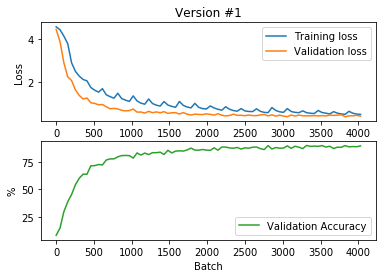

In [24]:
plot_parameters(parameters)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [26]:
# Initialize loss variables
test_losses, test_accuracies = [], []

# Get latest parameter version
latest_parameters = len(parameters)

# Do validation on the test set
test_image_classifier(device, model, criterion, test_loader, test_losses, test_accuracies)
            
print("Test loss: {}".format(test_losses[-1]))
print("Accuracy: {}".format(test_accuracies[-1]))

# Finally, store results of this attempt in dictionary
parameters[latest_parameters]['test_losses'] = np.array(test_losses)
parameters[latest_parameters]['test_accuracies'] = np.array(test_accuracies)

Test loss: 0.4517239974095271
Accuracy: 0.8856907899563129


In [27]:
print_parameters(parameters)

***********************************************
Model parameters of version #1
***********************************************

model: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

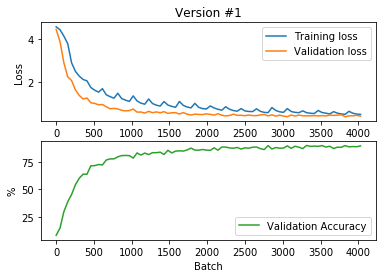

In [28]:
plot_parameters(parameters)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [29]:
def save_checkpoint(model, parameters):
    """
    Save parameters dictionary containing model parameters and model to disk.
    """   
    latest_parameters = len(parameters)
    
    # Store mapping between classes and indices from dataset in model
    model.class_to_idx = train_datasets.class_to_idx
    
    # Store in parameters the state dict (weights and biases) and the classes/indices mapping
    parameters[latest_parameters]['class_to_idx'] = model.class_to_idx
    parameters[latest_parameters]['state_dict'] = model.state_dict()
    
    # Save model to checkpoint file
    torch.save(parameters, 'checkpoint_{}.pth'.format(latest_parameters))
    

In [30]:
save_checkpoint(model, parameters)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [31]:
# Load the model from checkpoint file
def load_model_from_checkpoint(file, device):
    if device == 'cuda':
        # Load all tensors onto GPU
        map_location=lambda storage, loc: storage.cuda()
    else:
        # Load all tensors onto CPU
        map_location=lambda storage, loc: storage

    parameters = torch.load(file, map_location=map_location)

    latest_parameters = len(parameters)
    
    model = create_model(parameters[latest_parameters])
    
    model.class_to_idx = parameters[latest_parameters]['class_to_idx']
    model.load_state_dict(parameters[latest_parameters]['state_dict'], strict=False)
    
    return model, parameters

In [32]:
# Define 'cuda' as device if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model, parameters = load_model_from_checkpoint('checkpoint_1.pth', device)

# Usage of negative log likelihood loss (because of log softmax)
criterion = nn.NLLLoss()

# Use Adam optimizer for parameter optimization of classifier parameters after backpropagation 
optimizer = optim.Adam(model.classifier.parameters(), lr=parameters[len(parameters)].get('learning_rate', 0.0001))

# Set device for model (Use of GPU or CPU)
model.to(device)
print("Device: ", device)
print("Model:" , model)

Model succesfully created
Device:  cuda
Model: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [33]:
print_parameters(parameters)

***********************************************
Model parameters of version #1
***********************************************

model: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

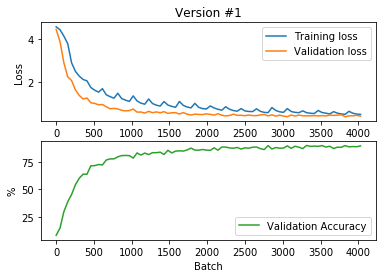

In [34]:
plot_parameters(parameters)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [35]:
# Process a PIL image for use in a PyTorch model
def process_image(pil_im):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    size = (256, 256)
    crop_len = 224
    
    # Resize the image to 256x256
    pil_im = pil_im.resize((size))
        
    # Crop the center 224x224 portion of the image
    # Left, Top = 0, 0
    # Right, Bottom = 256, 256
    left = (pil_im.width - crop_len)/2
    top = (pil_im.height - crop_len)/2
    right = left + crop_len
    bottom = top + crop_len
    pil_im = pil_im.crop((left, top, right, bottom))
    
    # Convert from PIL image to numpy array and change channel encoding from 0-255 to floats from 0-1
    # np_im = np.array(pil_im)
    np_im = np.array(pil_im) / 255
    
    # Color channel normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_im = (np_im - mean) / std

    # The color channel is the third dimension in the PIL image and Numpy array.
    # It needs to be the first dimension. The order of the other two dimensions need to be retained.
    return np_im.transpose((2, 0, 1))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [36]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    # Set title
    if title:
        ax.set_title(title)
   
    ax.imshow(image) 
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [40]:
def predict(image_path, model, topk=5):
    '''
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Arguments:
    image_path
                str          - Provide the path to the image file. 
                torch.Tensor - Image already transformed (resize, crop, color channel normalization) provided as torch.Tensor  
    '''
    
    # Image path is path to an image file
    if type(image_path) == str:
        # Open image as PIL image
        with Image.open(image_path) as im:
            # Pre process the image similar to what
            im = process_image(im)
        
        # Convert to ndarray to tensor and respective type depending on, if GPU is available
        im_t = torch.tensor(im)
        
        # Ensure that image tensor is converted to FloatTensor type
        im_t = im_t.type(torch.FloatTensor)
        
        im_t = im_t.to(device)
        
    # image_path already is a tensor
    elif torch.is_tensor(image_path):
        
        im_t = image_path
    
    # Add the batch dimension to the tensor (train )
    im_t = torch.unsqueeze(im_t, 0)
    
    # Enable test mode, which disables dopouts
    model.eval()

    with torch.no_grad():
        # Forward feed the model with the image
        output = model.forward(im_t)
        
        # Calculate probability (because model returns logsoftmax)
        ps = torch.exp(output)
    
        # Get the best probability value and it's index
        top_p, top_k = ps.topk(topk, dim=1)
    
    return top_p, top_k

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [38]:
def get_class_labels_top_k(top_k, class_to_idx, class_to_label):
    """
    Return the text labels of the top k classifications as list. 
    In case the index does not exist, None is returned as label.
    
    Arguments:
    top_k,               torch.Tensor,  top classification index values predicted by the model
    class_to_idx,        Dictionary,    mapping between model classification index and numbered classification labels
                                        determined by data loader ImageFolder (see directory structure)
    class_to_label,      Dictionary,    mapping between numbered classification labels and text labels

    return:
    class_labels_top_k,  list,          text labels of the top k classifications as list
    
    
    """
    # Flatten to 1D tensor and convert to ndarray
    top_k = np.array(np.squeeze(top_k))

    # top_k represents an class index provided by model prediction
    # Get the label from the class that matches the top k index
    class_labels_top_k = [class_to_label.get(cls, None) for k in top_k for cls, idx in class_to_idx.items() if k == idx]
    
    # Return list
    return class_labels_top_k

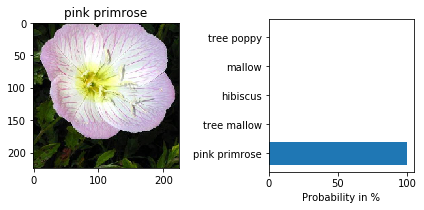

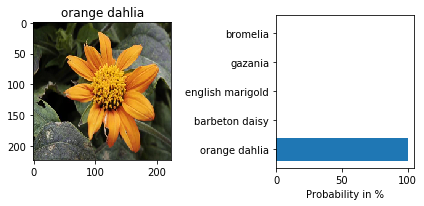

In [43]:
# Display an image along with the top 5 classes

# Image file paths and correct classifications
images = ["flowers/test/1/image_06743.jpg", "flowers/test/59/image_05052.jpg"]
labels = [cat_to_name.get("1", None), cat_to_name.get("59", None)]
img_range = range(len(images))

# Alternative: Get images from DataLoader
#images, labels_idx = next(iter(test_loader))
#img_range = range(parameters[len(parameters)].get('batch_size_data_loader', 1))
#labels = get_class_labels_top_k(labels_idx, model.class_to_idx, cat_to_name)

# Loop over all images
for i in img_range:
    image_path = images[i]
    title = labels[i]
               
    # Get probability and class
    top_p, top_k = predict(image_path, model, topk=5)

    # Get text labels of the top k classifications as list
    y = get_class_labels_top_k(top_k, model.class_to_idx, cat_to_name)

    # Flatten to 1D tensor and calculate percentage
    x = np.squeeze(top_p) * 100

    if type(image_path) == str:
        # Open image as PIL image
        with Image.open(image_path) as im:
            # Pre process the image similar to what
            im = process_image(im)
    # image_path already is a tensor
    elif torch.is_tensor(image_path):
         im = image_path

    # Create subplot with 2 rows
    fig, ax = plt.subplots(figsize=(6,3), ncols=2)

    # Display image in first row
    imshow(im, ax=ax[0], title=title)

    # Display top_k plot in second row
    y_pos = np.arange(len(y))
    ax[1].barh(y_pos, x)
    ax[1].set_yticks(y_pos)
    ax[1].set_yticklabels(y)
    ax[1].set_xlabel("Probability in %")
    plt.tight_layout()
